In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
import nltk
import re, string, unicodedata
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder 
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
import re
from collections import Counter
from nltk import ngrams
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
import pandas as pd
import tensorflow as tf
import numpy as np
from tabulate import tabulate
from tqdm import trange
import random
model_name = 'bert-base-uncased'
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)
tokenizer = BertTokenizer.from_pretrained(model_name)


c:\Users\User\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architect

In [28]:
df = pd.read_csv('final_data.csv')
df.head()

Title  \
0         Effect of edentulism on spirometric tests.   
1  Multiple Chronic Diseases Associated With Toot...   
2  Knowledge, attitudes and practices of patients...   
3  Asthma, chronic obstructive pulmonary disease,...   
4  A cohort study of the impact of tooth loss and...   

                                            Abstract  Label  
0  The impact of denture wear in edentulous subje...      1  
1  Half of US adults aged 20-64 years have lost a...      0  
2  Poor oral health is associated with worse clin...      0  
3  Adults with chronic respiratory conditions, sp...      0  
4  In COPD patients, fatal and non-fatal respirat...      0

In [29]:
df.replace("", float("NaN"), inplace=True)
df.dropna(inplace=True)
df.rename(columns = {"Title":"text", "Abstract":"text2", 'Label' : 'label'},inplace = True)
df

text  \
0           Effect of edentulism on spirometric tests.   
1    Multiple Chronic Diseases Associated With Toot...   
2    Knowledge, attitudes and practices of patients...   
3    Asthma, chronic obstructive pulmonary disease,...   
4    A cohort study of the impact of tooth loss and...   
..                                                 ...   
124  Treatment of obstructive sleep apnea using an ...   
125  Management of obstructive sleep apnea in an ed...   
126  Treatment of obstructive sleep apnoea in edent...   
127                  Managing obstructive sleep apnea.   
128  Mandibular advancement combined with horizonta...   

                                                 text2  label  
0    The impact of denture wear in edentulous subje...      1  
1    Half of US adults aged 20-64 years have lost a...      0  
2    Poor oral health is associated with worse clin...      0  
3    Adults with chronic respiratory conditions, sp...      0  
4    In COPD patients, fatal and non-fatal respirat...      0  
..                                                 ...    ...  
124  This paper reports on the case of an oral appl...      0  
125  Literature on the treatment of obstructive sle...      1  
126  This report describes the fabrication of a pro...      1  
127  Obstructive sleep apnea, cessation of breathin...      1  
128  Orthognathic surgical procedures have been use...      1  

[126 rows x 3 columns]

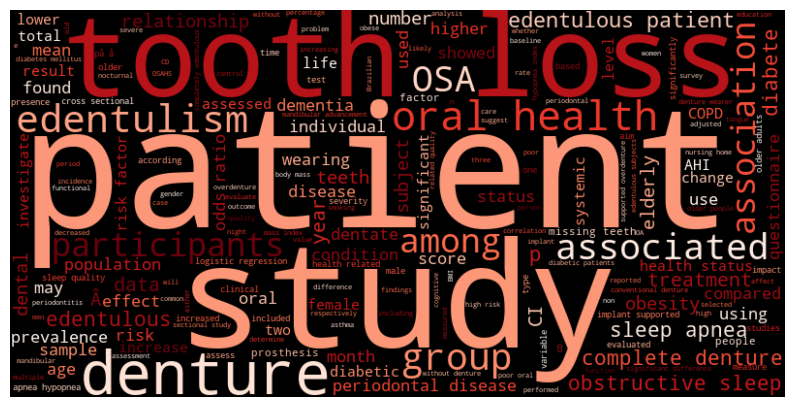

In [34]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text = df['text'].astype(str) + ' ' + df['text2'].astype(str)
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='Reds').generate(' '.join(text))

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [4]:
#lowercase, remove special characters

def cleansing(text):
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r'/(?<!\S).(?!\S)\s*/', '', text)
    return text

In [5]:
df['text'] = df['text'].apply(cleansing)
df['text2'] = df['text2'].apply(cleansing)
df


text  \
0            effect of edentulism on spirometric tests   
1    multiple chronic diseases associated with toot...   
2    knowledge attitudes and practices of patients ...   
3    asthma chronic obstructive pulmonary disease t...   
4    a cohort study of the impact of tooth loss and...   
..                                                 ...   
124  treatment of obstructive sleep apnea using an ...   
125  management of obstructive sleep apnea in an ed...   
126  treatment of obstructive sleep apnoea in edent...   
127                   managing obstructive sleep apnea   
128  mandibular advancement combined with horizonta...   

                                                 text2  label  
0    the impact of denture wear in edentulous subje...      1  
1    half of us adults aged  years have lost at lea...      0  
2    poor oral health is associated with worse clin...      0  
3    adults with chronic respiratory conditions spe...      0  
4    in copd patients fatal and nonfatal respirator...      0  
..                                                 ...    ...  
124  this paper reports on the case of an oral appl...      0  
125  literature on the treatment of obstructive sle...      1  
126  this report describes the fabrication of a pro...      1  
127  obstructive sleep apnea cessation of breathing...      1  
128  orthognathic surgical procedures have been use...      1  

[126 rows x 3 columns]

In [6]:
#remove stopwords 
stop_words = set(stopwords.words('english'))
df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df['text2'] = df['text2'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
df

text  \
0                  effect edentulism spirometric tests   
1    multiple chronic diseases associated tooth los...   
2    knowledge attitudes practices patients healthc...   
3    asthma chronic obstructive pulmonary disease t...   
4    cohort study impact tooth loss periodontal dis...   
..                                                 ...   
124  treatment obstructive sleep apnea using adjust...   
125  management obstructive sleep apnea edentulous ...   
126  treatment obstructive sleep apnoea edentulous ...   
127                   managing obstructive sleep apnea   
128  mandibular advancement combined horizontal adv...   

                                                 text2  label  
0    impact denture wear edentulous subjects perfor...      1  
1    half us adults aged years lost least one perma...      0  
2    poor oral health associated worse clinical out...      0  
3    adults chronic respiratory conditions specific...      0  
4    copd patients fatal nonfatal respiratoryrelate...      0  
..                                                 ...    ...  
124  paper reports case oral appliance used treatme...      0  
125  literature treatment obstructive sleep apnea e...      1  
126  report describes fabrication prosthesis preven...      1  
127  obstructive sleep apnea cessation breathing sl...      1  
128  orthognathic surgical procedures used past tre...      1  

[126 rows x 3 columns]

In [7]:
def preprocess_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text) 
    text = re.sub(r'\s+', ' ', text)  
    return text.strip()

# Apply text preprocessing to 'text' and 'text2' columns
df['text'] = df['text'].apply(preprocess_text)
df['text2'] = df['text2'].apply(preprocess_text)

print(df.dtypes)

text     object
text2    object
label     int64
dtype: object


In [8]:
df


text  \
0                  effect edentulism spirometric tests   
1    multiple chronic diseases associated tooth los...   
2    knowledge attitudes practices patients healthc...   
3    asthma chronic obstructive pulmonary disease t...   
4    cohort study impact tooth loss periodontal dis...   
..                                                 ...   
124  treatment obstructive sleep apnea using adjust...   
125  management obstructive sleep apnea edentulous ...   
126  treatment obstructive sleep apnoea edentulous ...   
127                   managing obstructive sleep apnea   
128  mandibular advancement combined horizontal adv...   

                                                 text2  label  
0    impact denture wear edentulous subjects perfor...      1  
1    half us adults aged years lost least one perma...      0  
2    poor oral health associated worse clinical out...      0  
3    adults chronic respiratory conditions specific...      0  
4    copd patients fatal nonfatal respiratoryrelate...      0  
..                                                 ...    ...  
124  paper reports case oral appliance used treatme...      0  
125  literature treatment obstructive sleep apnea e...      1  
126  report describes fabrication prosthesis preven...      1  
127  obstructive sleep apnea cessation breathing sl...      1  
128  orthognathic surgical procedures used past tre...      1  

[126 rows x 3 columns]

In [9]:
X = df[['text', 'text2']] 
y = df['label']  

#label encoder
label_encoder = LabelEncoder()
X['text'] = label_encoder.fit_transform(X['text'])
X['text2'] = label_encoder.fit_transform(X['text2'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train set shape:", X_train.shape, y_train.shape)
print("Test set shape:", X_test.shape, y_test.shape)

Train set shape: (100, 2) (100,)
Test set shape: (26, 2) (26,)


C:\Users\User\AppData\Local\Temp\ipykernel_25848\2413481960.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['text'] = label_encoder.fit_transform(X['text'])
C:\Users\User\AppData\Local\Temp\ipykernel_25848\2413481960.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['text2'] = label_encoder.fit_transform(X['text2'])


In [14]:
from imblearn.over_sampling import SMOTE


smote = SMOTE(random_state=42)
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train, y_train)
print("Oversampled Train set shape:", X_train_oversampled.shape, y_train_oversampled.shape)

Oversampled Train set shape: (176, 2) (176,)


In [16]:
df_oversampled = pd.DataFrame(X_train_oversampled, columns=['text', 'text2'])
df_oversampled['label'] = y_train_oversampled

# Print the shape of the oversampled training set
print("Oversampled Train set shape:", df_oversampled.shape)

Oversampled Train set shape: (176, 3)


In [23]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
import torch


class CustomDataset(Dataset):
    def __init__(self, texts, text2s, labels):
        self.texts = texts
        self.text2s = text2s
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        text = self.texts[index]
        text2 = self.text2s[index]
        label = self.labels[index]
        return text, text2, label


# Initialize the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Tokenize the text and convert it into input tensors
def tokenize_function(texts, text2s):
    inputs = tokenizer.batch_encode_plus(
        list(zip(texts, text2s)),
        add_special_tokens=True,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    return inputs

train_texts = df_oversampled['text'].tolist()
train_text2s = df_oversampled['text2'].tolist()
train_labels = df_oversampled['label'].tolist()

train_texts = [str(text) for text in train_texts]
train_text2s = [str(text2) for text2 in train_text2s]

train_dataset = CustomDataset(train_texts, train_text2s, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Set the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


optimizer = AdamW(model.parameters(), lr=2e-5)

model.train()
for epoch in range(10):
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    for step, batch in enumerate(train_dataloader):
        texts, text2s, labels = batch

        inputs = tokenize_function(texts, text2s)
        inputs = {key: val.to(device) for key, val in inputs.items()}
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()

        _, predicted_labels = torch.max(logits, dim=1)
        correct_predictions += torch.sum(predicted_labels == labels).item()
        total_predictions += labels.size(0)

        loss.backward()
        optimizer.step()

        if (step + 1) % 100 == 0:
            accuracy = correct_predictions / total_predictions
            avg_loss = total_loss / (step + 1)
            print(f'Step {step + 1} - Loss: {avg_loss:.4f} - Accuracy: {accuracy:.4f}')

    accuracy = correct_predictions / total_predictions
    avg_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1} - Average Loss: {avg_loss:.4f} - Accuracy: {accuracy:.4f}')

model.save_pretrained('bert')
tokenizer.save_pretrained('tokenizer')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch 1 - Average Loss: 0.7355 - Accuracy: 0.4830
Epoch 2 - Average Loss: 0.6817 - Accuracy: 0.5511
Epoch 3 - Average Loss: 0.6205 - Accuracy: 0.6534
Epoch 4 - Average Loss: 0.5706 - Accuracy: 0.7557
Epoch 5 - Average Loss: 0.5183 - Accuracy: 0.7557
Epoch 6 - Average Loss: 0.4561 - Accuracy: 0.7898
Epoch 7 - Average Loss: 0.4102 - Accuracy: 0.8011
Epoch 8 - Average Loss: 0.4135 - Accuracy: 0.8068
Epoch 9 - Average Loss: 0.3036 - Accuracy: 0.8920
Epoch 10 - Average Loss: 0.3095 - Accuracy: 0.8580


('tokenizer\\tokenizer_config.json',
 'tokenizer\\special_tokens_map.json',
 'tokenizer\\vocab.txt',
 'tokenizer\\added_tokens.json')

In [24]:
from sklearn.metrics import classification_report

# ...

model.eval()
y_true = []
y_pred = []

for step, batch in enumerate(train_dataloader):
    texts, text2s, labels = batch

    inputs = tokenize_function(texts, text2s)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(**inputs, labels=labels)
        logits = outputs.logits

    _, predicted_labels = torch.max(logits, dim=1)

    y_true.extend(labels.detach().cpu().numpy())
    y_pred.extend(predicted_labels.detach().cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

report = classification_report(y_true, y_pred)
print(report)


              precision    recall  f1-score   support

           0       1.00      0.62      0.77        88
           1       0.73      1.00      0.84        88

    accuracy                           0.81       176
   macro avg       0.86      0.81      0.81       176
weighted avg       0.86      0.81      0.81       176



Text(50.722222222222214, 0.5, 'Truth')

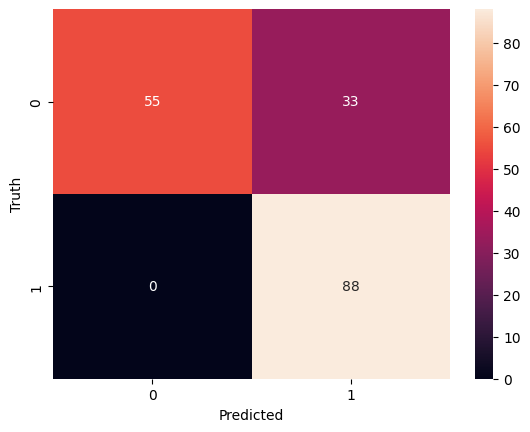

In [25]:
import seaborn as sn
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [45]:
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
import torch

class CustomDataset(Dataset):
    def __init__(self, texts, text2s, labels):
        self.texts = texts
        self.text2s = text2s
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        text = self.texts[index]
        text2 = self.text2s[index]
        label = self.labels[index]
        return text, text2, label


# Initialize the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Tokenize the text and convert it into input tensors
def tokenize_function(texts, text2s):
    inputs = tokenizer.batch_encode_plus(
        list(zip(texts, text2s)),
        add_special_tokens=True,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    return inputs

train_texts = df_oversampled['text'].tolist()
train_text2s = df_oversampled['text2'].tolist()
train_labels = df_oversampled['label'].tolist()

train_texts = [str(text) for text in train_texts]
train_text2s = [str(text2) for text2 in train_text2s]

train_dataset = CustomDataset(train_texts, train_text2s, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Set the device for training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)

# Early stopping parameters
early_stopping_epochs = 15
best_loss = float('inf')
best_model = None
epochs_without_improvement = 0

model.train()
for epoch in range(32):
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0
    
    for step, batch in enumerate(train_dataloader):
        texts, text2s, labels = batch

        inputs = tokenize_function(texts, text2s)
        inputs = {key: val.to(device) for key, val in inputs.items()}
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        total_loss += loss.item()

        _, predicted_labels = torch.max(logits, dim=1)
        correct_predictions += torch.sum(predicted_labels == labels).item()
        total_predictions += labels.size(0)

        loss.backward()
        optimizer.step()

        if (step + 1) % 100 == 0:
            accuracy = correct_predictions / total_predictions
            avg_loss = total_loss / (step + 1)
            print(f'Step {step + 1} - Loss: {avg_loss:.4f} - Accuracy: {accuracy:.4f}')

    accuracy = correct_predictions / total_predictions
    avg_loss = total_loss / len(train_dataloader)
    print(f'Epoch {epoch + 1} - Average Loss: {avg_loss:.4f} - Accuracy: {accuracy:.4f}')

    # Check if validation loss has improved
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_model = model.state_dict()
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    # Stop training if there have been no improvements for a certain number of epochs
    if epochs_without_improvement >= early_stopping_epochs:
        print(f'Early stopping. No improvement in {early_stopping_epochs} epochs.')
        break

# Save the best model and tokenizer
torch.save(best_model, 'best_model')
tokenizer.save_pretrained('tokenizer')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch 1 - Average Loss: 0.6980 - Accuracy: 0.5341
Epoch 2 - Average Loss: 0.6577 - Accuracy: 0.6250
Epoch 3 - Average Loss: 0.5786 - Accuracy: 0.7330
Epoch 4 - Average Loss: 0.5192 - Accuracy: 0.7557
Epoch 5 - Average Loss: 0.5043 - Accuracy: 0.7614
Epoch 6 - Average Loss: 0.4377 - Accuracy: 0.8011
Epoch 7 - Average Loss: 0.3957 - Accuracy: 0.8239
Epoch 8 - Average Loss: 0.2939 - Accuracy: 0.9091
Epoch 9 - Average Loss: 0.2533 - Accuracy: 0.8920
Epoch 10 - Average Loss: 0.1847 - Accuracy: 0.9261
Epoch 11 - Average Loss: 0.1461 - Accuracy: 0.9489
Epoch 12 - Average Loss: 0.1814 - Accuracy: 0.9432
Epoch 13 - Average Loss: 0.1255 - Accuracy: 0.9545
Epoch 14 - Average Loss: 0.0746 - Accuracy: 0.9773
Epoch 15 - Average Loss: 0.0481 - Accuracy: 0.9886
Epoch 16 - Average Loss: 0.0787 - Accuracy: 0.9716
Epoch 17 - Average Loss: 0.0404 - Accuracy: 0.9886
Epoch 18 - Average Loss: 0.0222 - Accuracy: 0.9943
Epoch 19 - Average Loss: 0.0421 - Accuracy: 0.9886
Epoch 20 - Average Loss: 0.0177 - Accura

('tokenizer\\tokenizer_config.json',
 'tokenizer\\special_tokens_map.json',
 'tokenizer\\vocab.txt',
 'tokenizer\\added_tokens.json')

In [46]:
from sklearn.metrics import classification_report

model.eval()
y_true = []
y_pred = []

for step, batch in enumerate(train_dataloader):
    texts, text2s, labels = batch

    inputs = tokenize_function(texts, text2s)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    labels = labels.to(device)

    with torch.no_grad():
        outputs = model(**inputs, labels=labels)
        logits = outputs.logits

    _, predicted_labels = torch.max(logits, dim=1)

    y_true.extend(labels.detach().cpu().numpy())
    y_pred.extend(predicted_labels.detach().cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

report = classification_report(y_true, y_pred)
print(report)


              precision    recall  f1-score   support

           0       1.00      0.99      0.99        88
           1       0.99      1.00      0.99        88

    accuracy                           0.99       176
   macro avg       0.99      0.99      0.99       176
weighted avg       0.99      0.99      0.99       176



Text(50.722222222222214, 0.5, 'Truth')

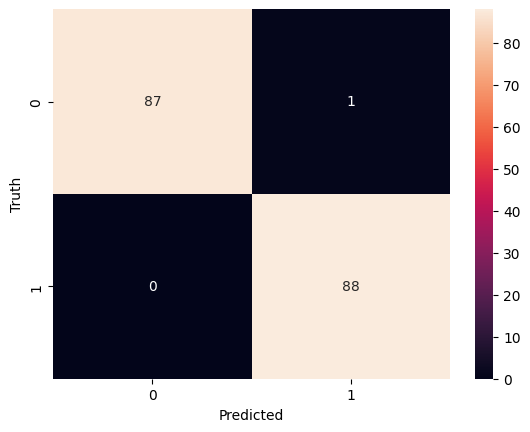

In [47]:
import seaborn as sn
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')